In [21]:
import numpy as np
import random
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import influence_plot
%matplotlib inline

# a utility function to only show the coefficient section of summary
from IPython.core.display import HTML
def short_summary(est):
    return HTML(est.summary().tables[1].as_html())
        
def dummify(df,column):
    print '{} is your baseline'.format(sorted(df[column].unique())[-1])
    dummy = pd.get_dummies(df[column]).rename(columns=lambda x: column+'_'+str(x)).iloc[:,0:len(df[column].unique())-1]
    df = df.drop(column,axis=1) #Why not inplace? because if we do inplace, it will affect the df directly
    return pd.concat([df,dummy],axis=1)

In [22]:
df_gnp = pd.read_csv('http://vincentarelbundock.github.io/Rdatasets/csv/datasets/longley.csv', index_col=0)
df_gnp.head()

,GNP.deflator,GNP,Unemployed,Armed.Forces,Population,Year,Employed
1947,83.0,234.289,235.6,159.0,107.608,1947,60.323
1948,88.5,259.426,232.5,145.6,108.632,1948,61.122
1949,88.2,258.054,368.2,161.6,109.773,1949,60.171
1950,89.5,284.599,335.1,165.0,110.929,1950,61.187
1951,96.2,328.975,209.9,309.9,112.075,1951,63.221


In [23]:
X = df_gnp.GNP
X = sm.add_constant(X)
y= df_gnp.Employed

In [24]:
est = sm.OLS(y,X)
est = est.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Employed   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     415.1
Date:                Mon, 15 Aug 2016   Prob (F-statistic):           8.36e-12
Time:                        20:32:29   Log-Likelihood:                -14.904
No. Observations:                  16   AIC:                             33.81
Df Residuals:                      14   BIC:                             35.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         51.8436      0.681     76.087      0.000        50.382    53.305
GNP            0.0348      0.002     20.374      0.000         0.031     0.038
==============================================================================
Omnibus:                        1.925   Durbin-Watson:                   1.619
Prob(Omnibus):                  0.382   Jarque-Bera (JB):                1.215
Skew:                           0.664   Prob(JB):                        0.545
Kurtosis:                       2.759   Cond. No.                     1.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

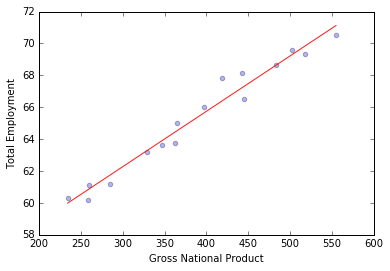

In [25]:
# We pick 100 hundred points equally spaced from the min to the max
X_prime = np.linspace(X.GNP.min(), X.GNP.max(), 100)[:, np.newaxis]
X_prime = sm.add_constant(X_prime)  # add constant as we did before

# Now we calculate the predicted values
y_hat = est.predict(X_prime)

plt.scatter(X.GNP, y, alpha=0.3)  # Plot the raw data
plt.xlabel("Gross National Product")
plt.ylabel("Total Employment")
plt.plot(X_prime[:, 1], y_hat, 'r', alpha=0.9)  # Add the regression line, colored in red

In [26]:
def influence_plotter(y_delta,x_delta,y,X):
    y.ix[9999] = y_delta#y.iloc[10]+y_delta
    X.loc[9999,'GNP'] = x_delta#X['GNP'].iloc[10]+x_delta
    X.loc[9999,'const'] = 1
    est = sm.OLS(y, X)
    est = est.fit()
    est.summary()

    # We pick 100 hundred points equally spaced from the min to the max
    X_prime = np.linspace(X.GNP.min(), X.GNP.max(), 100)[:, np.newaxis]
    X_prime = sm.add_constant(X_prime)  # add constant as we did before
    # Now we calculate the predicted values
    y_hat1 = est.predict(X_prime)

    plt.scatter(X.GNP, y, alpha=0.3)  # Plot the raw data
    plt.scatter(X.GNP[9999],y.ix[9999],alpha=1, color='green')
    plt.xlabel("Gross National Product")
    plt.ylabel("Total Employment")
    plt.plot(X_prime[:, 1], y_hat1, 'g', alpha=0.9)
    plt.plot(X_prime[:, 1], y_hat, 'r', alpha=0.9)
    influence_plot(est)
    est.summary()

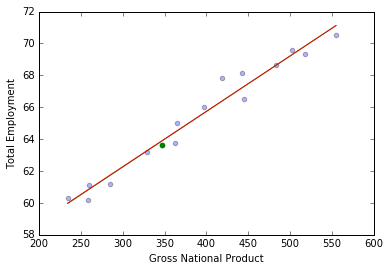

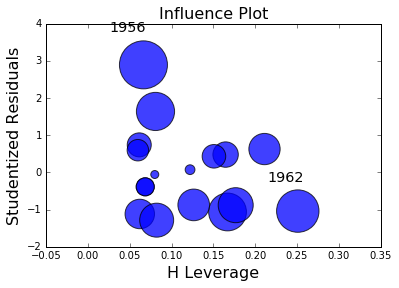

In [27]:
# Let's see what happens to our regression line under different types of outliers
influence_plotter(y.iloc[5],X.iloc[5,1],y,X)

In [28]:
# Let's revisit the bootstrap, just for funsies

def get_betas(X,y):
    beta0,beta1 = np.dot(np.linalg.inv(np.dot(X.T,X)),(np.dot(X.T,y)))
    return beta0,beta1

def bootstrap_df(df,y):
    indices = [random.choice(df.index) for _ in df.index]
    new_df= pd.DataFrame()
    new_y = []
    for element in indices:
        new_df = new_df.append(df.loc[element])
        new_y.append(y[element])
    return new_df,new_y

def bootstrap_betas(X,y,num_samples):
    return [get_betas(*bootstrap_df(X,y)) for _ in range(num_samples)]

In [29]:
print np.percentile([x[0] for x in bootstrap_betas(X,y,1000)],2.5)
print np.percentile([x[0] for x in bootstrap_betas(X,y,1000)],97.5)
print np.percentile([x[1] for x in bootstrap_betas(X,y,1000)],2.5)
print np.percentile([x[1] for x in bootstrap_betas(X,y,1000)],97.5)

0.0327002048715
0.0380940226099
50.5821775423
52.6663784178


In [30]:
print np.std([x[0] for x in bootstrap_betas(X,y,1000)])
print np.std([x[1] for x in bootstrap_betas(X,y,1000)])

0.0015457000465
0.580595382648


In [31]:
print np.mean([x[0] for x in bootstrap_betas(X,y,1000)])
print np.mean([x[1] for x in bootstrap_betas(X,y,1000)])

0.0350664696391
51.7360420247


In [32]:
df_cred = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Credit.csv', index_col=0)
df_cred.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [33]:
#Let's fit a simple model using the fancy formulas
est=smf.ols(formula = 'Balance ~ Income + Student',data=df_cred).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     76.22
Date:                Mon, 15 Aug 2016   Prob (F-statistic):           9.64e-29
Time:                        20:36:58   Log-Likelihood:                -2954.4
No. Observations:                 400   AIC:                             5915.
Df Residuals:                     397   BIC:                             5927.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept        211.1430     32.457      6.505      0.000       147.333   274.952
Student[T.Yes]   382.6705     65.311      5.859      0.000       254.272   511.069
Income             5.9843      0.557     10.751      0.000         4.890     7.079
==============================================================================
Omnibus:                      119.719   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.617
Skew:                           0.252   Prob(JB):                     7.44e-06
Kurtosis:                       1.922   Cond. No.                         192.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
#adding dummies to the model
dummies = pd.get_dummies(df_cred['Married']).rename(columns = lambda x: 'Married_'+str(x))
df_cred = pd.concat([df_cred,dummies],axis=1)

In [35]:
# Perfect collinearity, but statsmodels doesn't care
df_cred = sm.add_constant(df_cred)
sm.OLS(df_cred['Balance'],(df_cred[['Income','Married_No','Married_Yes','const']])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     54.52
Date:                Mon, 15 Aug 2016   Prob (F-statistic):           1.20e-21
Time:                        20:36:58   Log-Likelihood:                -2970.8
No. Observations:                 400   AIC:                             5948.
Df Residuals:                     397   BIC:                             5960.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Income          6.0587      0.580     10.441      0.000         4.918     7.199
Married_No     93.2788     24.831      3.757      0.000        44.462   142.095
Married_Yes    72.3242     22.603      3.200      0.001        27.888   116.760
const         165.6031     22.297      7.427      0.000       121.769   209.438
==============================================================================
Omnibus:                       44.240   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.104
Skew:                           0.380   Prob(JB):                     2.61e-05
Kurtosis:                       2.170   Cond. No.                     5.84e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.85e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [36]:
#LOOK AT THE R2!!!!!!!! WHAT?!?!?!
est=smf.ols(formula = 'Balance ~ Income-1',data=df_cred).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     620.0
Date:                Mon, 15 Aug 2016   Prob (F-statistic):           2.99e-83
Time:                        20:36:58   Log-Likelihood:                -2996.9
No. Observations:                 400   AIC:                             5996.
Df Residuals:                     399   BIC:                             6000.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Income         9.4429      0.379     24.899      0.000         8.697    10.189
==============================================================================
Omnibus:                        7.690   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                6.591
Skew:                           0.239   Prob(JB):                       0.0371
Kurtosis:                       2.591   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
est=smf.ols(formula = 'Balance ~ Income +Married_Yes-1',data=df_cred).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     328.1
Date:                Mon, 15 Aug 2016   Prob (F-statistic):           6.46e-85
Time:                        20:36:58   Log-Likelihood:                -2989.6
No. Observations:                 400   AIC:                             5983.
Df Residuals:                     398   BIC:                             5991.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Income          8.2748      0.481     17.214      0.000         7.330     9.220
Married_Yes   135.5044     35.198      3.850      0.000        66.307   204.702
==============================================================================
Omnibus:                       11.184   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                9.716
Skew:                           0.311   Prob(JB):                      0.00777
Kurtosis:                       2.558   Cond. No.                         94.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
#use my fancy little dummy function
dummify(df_cred,'Ethnicity')

Caucasian is your baseline


,const,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance,Married_No,Married_Yes,Ethnicity_African American,Ethnicity_Asian
1,1,14.891,3606,283,2,34,11,Male,No,Yes,333,0.0,1.0,0.0,0.0
2,1,106.025,6645,483,3,82,15,Female,Yes,Yes,903,0.0,1.0,0.0,1.0
3,1,104.593,7075,514,4,71,11,Male,No,No,580,1.0,0.0,0.0,1.0
4,1,148.924,9504,681,3,36,11,Female,No,No,964,1.0,0.0,0.0,1.0
5,1,55.882,4897,357,2,68,16,Male,No,Yes,331,0.0,1.0,0.0,0.0
6,1,80.180,8047,569,4,77,10,Male,No,No,1151,1.0,0.0,0.0,0.0
7,1,20.996,3388,259,2,37,12,Female,No,No,203,1.0,0.0,1.0,0.0
8,1,71.408,7114,512,2,87,9,Male,No,No,872,1.0,0.0,0.0,1.0
9,1,15.125,3300,266,5,66,13,Female,No,No,279,1.0,0.0,0.0,0.0
10,1,71.061,6819,491,3,41,19,Female,Yes,Yes,1350,0.0,1.0,1.0,0.0


In [39]:
df_adv = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)
df_adv.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [40]:
#Man, this formulas thing really tries to make you include stuff in the model
est=smf.ols(formula = 'Sales ~ TV*Radio-1-TV-Radio',data = df_adv).fit() #also TV:Radio
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     940.4
Date:                Mon, 15 Aug 2016   Prob (F-statistic):           2.45e-77
Time:                        20:36:58   Log-Likelihood:                -650.33
No. Observations:                 200   AIC:                             1303.
Df Residuals:                     199   BIC:                             1306.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
TV:Radio       0.0028   9.16e-05     30.666      0.000         0.003     0.003
==============================================================================
Omnibus:                       33.290   Durbin-Watson:                   1.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.235
Skew:                          -1.114   Prob(JB):                     2.48e-10
Kurtosis:                       3.584   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# load the boston housing dataset - median house values in the Boston area
df = pd.read_csv('http://vincentarelbundock.github.io/Rdatasets/csv/MASS/Boston.csv')
#del df['Unnamed: 0'] if you feel like deleting it
df.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


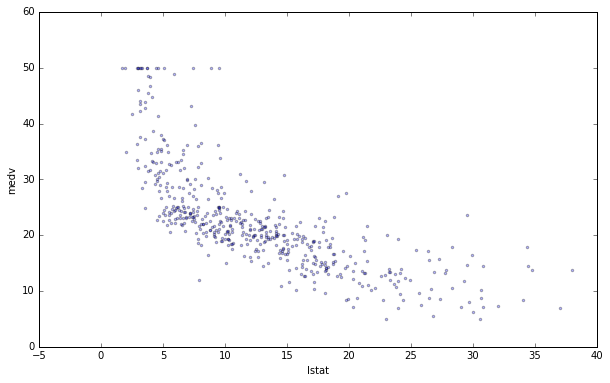

In [42]:
# plot lstat (% lower status of the population) against median value
# Doesn't look linear, does it?
plt.figure(figsize=(10, 6))
plt.scatter(df.lstat, df.medv, s=6, alpha=0.3)
plt.xlabel('lstat')
plt.ylabel('medv')

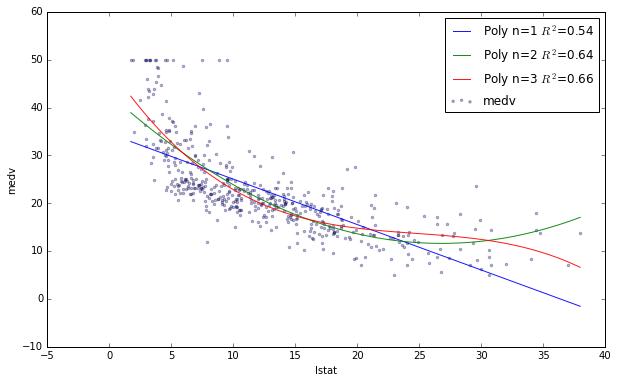

In [43]:
# Let's fit some lines to it!

# plot lstat (% lower status of the population) against median value
plt.figure(figsize=(10, 6))
plt.scatter(df.lstat, df.medv, s=6, alpha=0.3)
plt.xlabel('lstat')
plt.ylabel('medv')

# points linearly space on lstat
x = pd.DataFrame({'lstat': np.linspace(df.lstat.min(), df.lstat.max(), 100)})

# 1st order polynomial
poly_1 = smf.ols(formula='medv ~ 1 + lstat', data=df).fit()
plt.plot(x.lstat, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$={:.2f}'.format(poly_1.rsquared), 
         alpha=0.9)

# 2nd order polynomial
poly_2 = smf.ols(formula='medv ~ 1 + lstat + I(lstat ** 2.0)', data=df).fit()
plt.plot(x.lstat, poly_2.predict(x), 'g-', label='Poly n=2 $R^2$={:.2f}'.format(poly_2.rsquared), 
         alpha=0.9)

# 3rd order polynomial
poly_3 = smf.ols(formula='medv ~ 1 + lstat + I(lstat**2)+I(lstat**3)', data=df).fit()
plt.plot(x.lstat, poly_3.predict(x), 'r-', alpha=0.9,
         label='Poly n=3 $R^2$={:.2f}'.format(poly_3.rsquared))

plt.legend()

In [44]:
poly_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Mon, 15 Aug 2016   Prob (F-statistic):           5.08e-88
Time:                        20:36:59   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.000        33.448    35.659
lstat         -0.9500      0.039    -24.528      0.000        -1.026    -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""